In [6]:
# Import all my dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plot

In [7]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [8]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, asc
from sqlalchemy import inspect
from sqlalchemy.sql import func
from sqlalchemy import extract

In [9]:
import pymysql
pymysql.install_as_MySQLdb()

In [10]:
# step 1: establish connection to the engine (db) [5 steps]
# papa
engine = create_engine("sqlite:///hawaii.sqlite")
#prints the tables names directly form the "engine" 
#print(engine.table_names())

In [11]:
# optional: use inspect() to obtain table names
# Entry point to SQLAlchemy’s public API for viewing the configuration and construction of in-memory objects
# https://docs.sqlalchemy.org/en/latest/core/inspection.html
inspector = inspect(engine)
print(inspector.get_table_names())

['measurement', 'station']


In [12]:
# step 2: reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [13]:
# view all of the classes(tables) found using automap() 
Base.classes.keys()

['measurement', 'station']

In [14]:
# step 3: save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [15]:
# print(Measurement)
# what does "ext" in the output reference?

In [16]:
# step 4: create our session(link) to the DB
# nieto
session = Session(engine)

In [17]:
#station_list = session.query(Station).order_by(Station.name.desc())
#for one in station_list:
 #   print(one.name)

# Precipitation Analysis

In [18]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results:

# 1.calculate the date 1 year ago from the last data point in the database #'2017-08-23'
session.query(Measurement.date).order_by(Measurement.date.desc()).limit(5).all()
#for each in List:
#   print(each.date) 

[('2017-08-23'),
 ('2017-08-23'),
 ('2017-08-23'),
 ('2017-08-23'),
 ('2017-08-22')]

In [19]:
# 2.perform a query to retrieve the data and precipitation scores
#   displays all data from all columns in table "Measurements" for dates  2016-08-23 to 2017-08-23
prcp_data = session.query(Measurement).filter(Measurement.date <= '2017-08-23').\
        filter(Measurement.date >= '2016-08-23')

In [20]:
# 3.save the query results as a Pandas DataFrame 
precip_df = pd.read_sql_query(prcp_data.statement, session.bind)

In [21]:
# 3b.displays all data from columns: "date"(set as index), and "prcp"
data_index = precip_df[["date","prcp"]].set_index("date")

In [22]:
#data_index.to_dict()

In [23]:
# 4.sort the dataframe by date, and sum "prcp" data == showcasing total amount of precipitation per day
data_index.groupby(["date"]).sum().head()

,prcp
date,
2016-08-23,2.71
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32


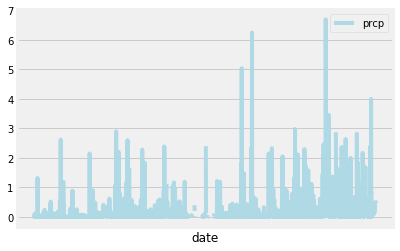

In [30]:
# 5.use Pandas Plotting with Matplotlib to plot the data 
plot_prcp = data_index.plot(color='lightblue', alpha=0.95)
plot.xticks([])
plot.xlabel("date")
plot.legend(loc=0)
plot.show(plot_prcp)

In [31]:
# 6.summary statistics for the precipitation data
data_index.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [32]:
# 7.query shows how many stations are available in this dataset
session.query(Station).count()

9

In [33]:
# 8.list most active stations and the counts in descending order
session.query(Measurement.station, func.count(Measurement.station).label('total')).group_by(Measurement.station).order_by('total DESC').all()

C:\Users\MARIA JOSE\Anaconda3\lib\site-packages\sqlalchemy\sql\compiler.py:643: SAWarning: Can't resolve label reference 'total DESC'; converting to text() (this warning may be suppressed after 10 occurrences)
  util.ellipses_string(element.element))


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [34]:
# 9. calculate the low temp,high temp, and avg temp using most active station
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [35]:
# Choose the station with the highest number of temperature observations. 

# 10.query the last 12 months of temperature observation data for this station
#  filter on table, col='USC00519281', and chosen date, order by number of tol ASC
pstation = session.query(Measurement.tobs, Measurement.date).filter(Measurement.station == 'USC00519281').filter(Measurement.date <= '2017-08-23').\
        filter(Measurement.date >= '2016-08-23')

In [36]:
# 10b.save query as Df  
popstationdf = pd.read_sql_query(pstation.statement, session.bind)

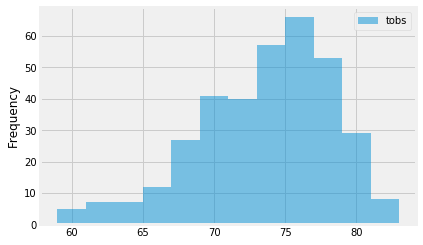

In [37]:
#plot histogram, bins=12
popular_station = plot.hist(popstationdf['tobs'], bins=12, alpha=0.5)
plot.ylabel("Frequency")
plot.legend(["tobs"])
plot.show(popular_station)

# Temperature Analysis of my Trip : 12-27-2015 to 01-10-2016

In [38]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
#print(calc_temps('2012-02-28', '2012-03-05'))

In [39]:
# 12. calculate MY TRIP's tmin, tavg, and tmax 
mytrip = print(calc_temps('2015-12-27', '2016-01-10'))
mytrip

[(62.0, 70.96551724137932, 78.0)]


In [40]:
from matplotlib.pyplot import figure

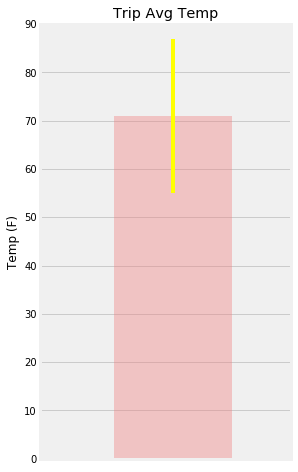

In [41]:
# 13. plot the results from your previous query as a bar chart. 
#     Use "Trip Avg Temp" as your Title
#     Use the average temperature for the y value
#     Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

mean = 70.96
peak2peak = 16
ind = 1    # the x locations for the groups

plot.figure(figsize=(4,8))
plot.xticks([])

plot.title("Trip Avg Temp")
plot.ylabel("Temp (F)")
plot.xlim(.10 , 1.8)
plot.ylim(0,90)

mytrip_temp = plot.bar(ind, mean, yerr=peak2peak, color='lightcoral', ecolor="yellow", align="center", alpha=0.4)

# Rainfall per Weather Station

In [42]:
stations_list=session.query(Station.station)
stations_df = pd.read_sql_query(stations_list.statement, session.bind)

In [43]:
stations_df.to_dict()

{'station': {0: 'USC00519397',
  1: 'USC00513117',
  2: 'USC00514830',
  3: 'USC00517948',
  4: 'USC00518838',
  5: 'USC00519523',
  6: 'USC00519281',
  7: 'USC00511918',
  8: 'USC00516128'}}

In [44]:
# 14. calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
alist = session.query(Measurement.station, func.sum(Measurement.prcp)).filter(Measurement.date <= '2016-01-10').\
        filter(Measurement.date >= '2015-12-27').group_by(Measurement.station)

In [45]:
# 14b. use function to pull out all data correspondent to the stations from the list of "station_results", in a form of a tupple 
def rainfall_pstation(name):
    """rainfall_pstation.
    
    Args:
        name (str): Name of station string in the format 'USC00519397'
        
    Returns:
        A list of tuples containing each result correspondant to each column in table "Stations"
    
    """
    sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation]
    return session.query(*sel).filter(Station.station == name).first()

In [46]:
# 14c.looped through the list filtered by station for my trip dates
stations_results = []
station_list = ['USC00513117','USC00514830', 'USC00516128', 'USC00517948', 'USC00519281', 'USC00519397','USC00519523']

for one in station_list:
    r=rainfall_pstation(one)
    stations_results.append(r)
    
# show results 
#stations_results

In [47]:
# 14d. create a df of station_results
stationinfo_df = pd.DataFrame(stations_results)
# create a df of rainfall results
rainfallinfo_df = pd.read_sql_query(alist.statement, session.bind)

In [48]:
# 14e. Display Results:
#      A.merge tables
#      B.sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
pd.merge(stationinfo_df, rainfallinfo_df, on="station", how="inner").sort_values(by=["sum_1"],ascending=False)

,station,name,latitude,longitude,elevation,sum_1
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,5.28
4,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2.54
0,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,1.42
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.67
6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.67
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.44
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


## Optional Challenge Assignment

In [49]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = (func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs))
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()


daily_normals("10-12")

[(65.0, 75.75510204081633, 82.0)]

In [50]:
# Calculate the daily normals for your trip

# A. created a for loop that runs through date_list, 
# B. pulls each "day" and plugs it in def daily_normals(),
# C. appends each return of (min, avg, max temp) into list date_results

date_results = []
date_list = ["12-27", "12-28", "12-29", "12-30","12-31", "01-01", "01-02", "01-03", "01-04", "01-05", "01-06", "01-07", "01-08", "01-09", "01-12"]

for day in date_list:
    abc=daily_normals(day)
    date_results.append(abc)

In [51]:
date_results

[[(62.0, 71.91666666666667, 79.0)],
 [(62.0, 70.52083333333333, 77.0)],
 [(57.0, 70.29166666666667, 78.0)],
 [(63.0, 69.86363636363636, 76.0)],
 [(56.0, 68.27906976744185, 77.0)],
 [(62.0, 69.15384615384616, 77.0)],
 [(60.0, 69.39622641509433, 77.0)],
 [(62.0, 68.9090909090909, 77.0)],
 [(58.0, 70.0, 76.0)],
 [(56.0, 67.96428571428571, 76.0)],
 [(61.0, 68.96491228070175, 76.0)],
 [(57.0, 68.54385964912281, 76.0)],
 [(57.0, 67.16071428571429, 75.0)],
 [(58.0, 67.9298245614035, 78.0)],
 [(57.0, 67.4074074074074, 81.0)]]